# Coursera IBM Capstone Project – Battle of the Neighborhoods

#### Problem Description

New York City (sometimes called the Big Apple or more simply “NYC”) is one of the most ethnically diverse and culturally rich cities in the world. With a population of over 8 million New York City is one of the most densely populated cities in the world. With the large number of diverse cultures and its high density, New York City has been labelled the “melting pot” of the US. There are as many as 800 languages spoken in New York City which makes it the most linguistically diverse city in the world. 

Given its rich and diverse culture it is no surprise that over 65 million tourists visited New York City in 2018. During the day many of these tourists visit the main sites and attractions in New York City which include the Statue of Liberty, Times Square and Central Park amongst others. New York City is also known as the “city that never sleeps” and many of these tourists are eager to sample the city’s nightlife culture and bars. The Irish are synonymous with the New York City and Irish Bars are viewed as being the best bars in many cities across the world as they have the best “craic”. 

In this project I will provide a summary of the best Irish Bars in New York City that tourists should visit.  

#### Description of Data To Be Used
There are three data sources that will be used to complete this project, namely:

1.	Data source: https://cocl.us/new_york_dataset
This data set contains the longitude and latitude of each borough and neighborhood in New York City. This information will be used to explore the various neighborhoods in each borough. 

2.	Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm 
This data set will enable us to visualise New York City Borough boundaries.

3.	Data source : Fousquare API 
This API will provide us a summary of the Irish bars in each borough and neighborhood across New York City. 


#### How Will This Data Be Used to Solve the Problem?
The approach to solving this problem is:
1.	Pull in the New York City borough and neighborhood from the data source: https://cocl.us/new_york_dataset.
2.	Use the FourSquare API to identify all venues in each borough and neighborhood.
3.	Identify the venues which are Irish Bars.
4.	Use the FourSquare API to find the average rating and tips for each Irish Bar.
5.	Using the data, identify the Irish Bars based on an average rating greater than 7.
6.	Produce a map of New York City that visualizes the location of the Irish Bars in each neighborhood. 


In [16]:
#Download and install geocoder and folium libraries
!pip install geocoder
!pip install folium

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')


Libraries imported.


In [17]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Define a function to interact with FourSquare API and return the venue id, name and category. In addition to getting the top 100 venues within a radius of 1000 metres for a given latitude and longitude.

In [18]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'RF5VVG4WY2M2DN3QUJIGFB45U2RRQPB1HOTWGG03S5Z4H2N1' # your Foursquare ID
    CLIENT_SECRET = 'AD3MPLRNSLPGLNS3NO1NXNM4TWCTSSZYFASSYA3GEW5SLEA1' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

We will define a function that will be used for ranking to get venue details such as ratings and tip counts for a given venue id.

In [19]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'RF5VVG4WY2M2DN3QUJIGFB45U2RRQPB1HOTWGG03S5Z4H2N1' # your Foursquare ID
    CLIENT_SECRET = 'AD3MPLRNSLPGLNS3NO1NXNM4TWCTSSZYFASSYA3GEW5SLEA1' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [20]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

The above function can be called to get the data from New York City.

In [21]:
# get new york data
new_york_data=get_new_york_data()

In [22]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [23]:
# lets find out the shape of out data set
new_york_data.shape

(306, 4)

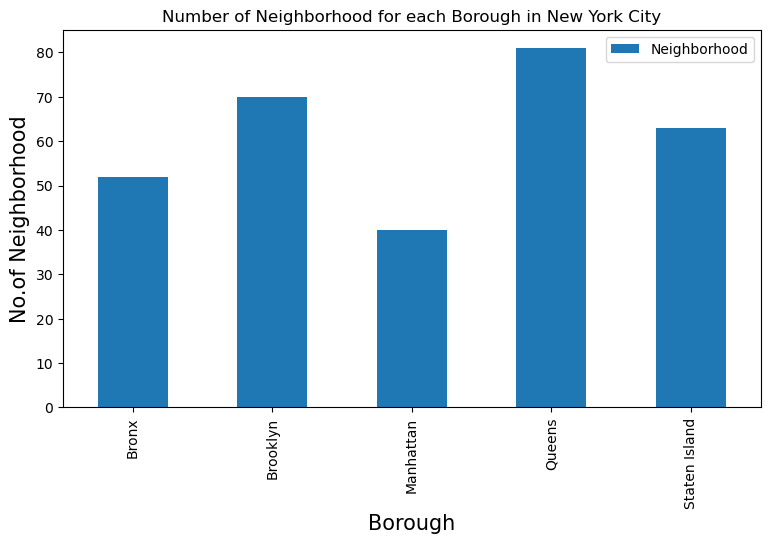

In [24]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

The above chart shows that Queens has the highest number of neighborhoods. 

In [25]:
# prepare neighborhood list that contains Irish Bars
column_names=['Borough', 'Neighborhood', 'ID','Name']
IrishPub_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    IrishPubs=venues[venues['Category']=='Irish Pub']   
    print('(',count,'/',len(new_york_data),')','Irish Pub in '+Neighborhood+', '+Borough+':'+str(len(IrishPubs)))
    for resturant_detail in IrishPubs.values.tolist():
        id, name , category=resturant_detail
        IrishPub_ny = IrishPub_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Irish Pub in Wakefield, Bronx:0
( 2 / 306 ) Irish Pub in Co-op City, Bronx:0
( 3 / 306 ) Irish Pub in Eastchester, Bronx:0
( 4 / 306 ) Irish Pub in Fieldston, Bronx:0
( 5 / 306 ) Irish Pub in Riverdale, Bronx:0
( 6 / 306 ) Irish Pub in Kingsbridge, Bronx:0
( 7 / 306 ) Irish Pub in Marble Hill, Manhattan:0
( 8 / 306 ) Irish Pub in Woodlawn, Bronx:0
( 9 / 306 ) Irish Pub in Norwood, Bronx:0
( 10 / 306 ) Irish Pub in Williamsbridge, Bronx:0
( 11 / 306 ) Irish Pub in Baychester, Bronx:0
( 12 / 306 ) Irish Pub in Pelham Parkway, Bronx:0
( 13 / 306 ) Irish Pub in City Island, Bronx:0
( 14 / 306 ) Irish Pub in Bedford Park, Bronx:0
( 15 / 306 ) Irish Pub in University Heights, Bronx:0
( 16 / 306 ) Irish Pub in Morris Heights, Bronx:0
( 17 / 306 ) Irish Pub in Fordham, Bronx:0
( 18 / 306 ) Irish Pub in East Tremont, Bronx:0
( 19 / 306 ) Irish Pub in West Farms, Bronx:0
( 20 / 306 ) Irish Pub in High  Bridge, Bronx:0
( 21 / 306 ) Irish Pub in Melrose, Bronx:0
( 22 / 306 ) Irish Pub 

( 166 / 306 ) Irish Pub in St. Albans, Queens:0
( 167 / 306 ) Irish Pub in Rochdale, Queens:0
( 168 / 306 ) Irish Pub in Springfield Gardens, Queens:0
( 169 / 306 ) Irish Pub in Cambria Heights, Queens:0
( 170 / 306 ) Irish Pub in Rosedale, Queens:0
( 171 / 306 ) Irish Pub in Far Rockaway, Queens:0
( 172 / 306 ) Irish Pub in Broad Channel, Queens:0
( 173 / 306 ) Irish Pub in Breezy Point, Queens:0
( 174 / 306 ) Irish Pub in Steinway, Queens:1
( 175 / 306 ) Irish Pub in Beechhurst, Queens:0
( 176 / 306 ) Irish Pub in Bay Terrace, Queens:0
( 177 / 306 ) Irish Pub in Edgemere, Queens:0
( 178 / 306 ) Irish Pub in Arverne, Queens:0
( 179 / 306 ) Irish Pub in Rockaway Beach, Queens:0
( 180 / 306 ) Irish Pub in Neponsit, Queens:0
( 181 / 306 ) Irish Pub in Murray Hill, Queens:0
( 182 / 306 ) Irish Pub in Floral Park, Queens:0
( 183 / 306 ) Irish Pub in Holliswood, Queens:0
( 184 / 306 ) Irish Pub in Jamaica Estates, Queens:0
( 185 / 306 ) Irish Pub in Queensboro Hill, Queens:0
( 186 / 306 ) I

In [26]:
IrishPub_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,North Riverdale,59f3a8d12f97ec6434ddf346,Downey’s Bar & Grill
1,Brooklyn,Bay Ridge,5678a8b0498ef875c752896e,Pipin's Pop Up
2,Brooklyn,Fort Hamilton,5678a8b0498ef875c752896e,Pipin's Pop Up
3,Queens,Astoria,56ef4e1c498ef700988cf679,Passage Irish Bar & Kitchen
4,Queens,Steinway,5a76763223a2e6307eec70ac,Jack Jones Bar


In [27]:
IrishPub_ny.shape

(8, 4)

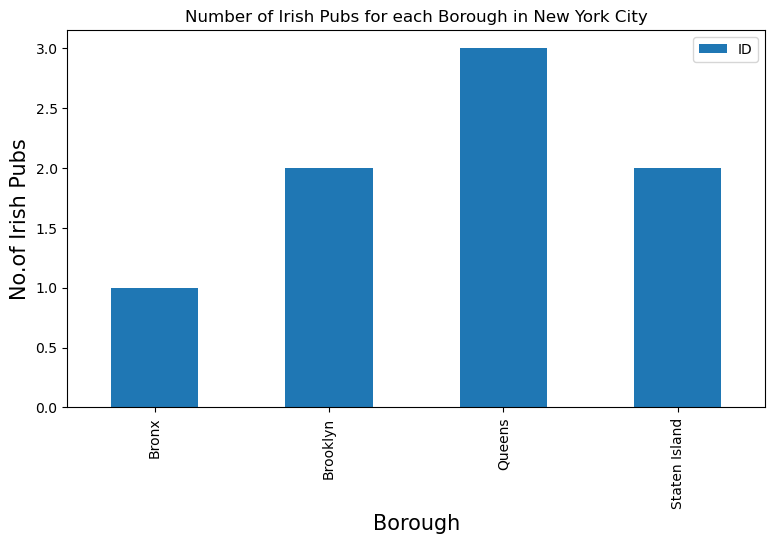

In [28]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Irish Pubs for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Irish Pubs', fontsize=15)
#giving a bar plot
IrishPub_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

It is evident from our chart that using the FourSquare API data that Queens is the suburb with the highest number of Irish Bars. It is also noted that the API has returned a very small number of Irish Bars whereas we know that there are hundreds of Irish Bars in NYC. Nonetheless I will continue with the analysis.

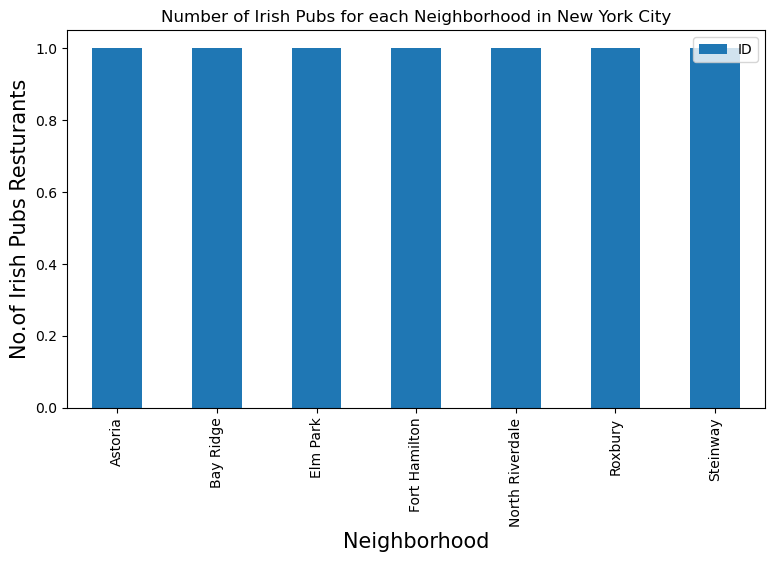

In [29]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Irish Pubs for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Irish Pubs Resturants', fontsize=15)
#giving a bar plot
IrishPub_ny.groupby('Neighborhood')['ID'].count().nlargest(7).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

It is seen that there are only seven Irish Bars with at most one in each neighborhood.

Now we will get the the number of likes, average rating and tips for each Irish Bar for further analysis.

In [30]:
# prepare neighborhood list that contains Irish Bars
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
IrishPub_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in IrishPub_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these Irish Bars as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(IrishPub_ny),')','processed')
    IrishPub_stats_ny = IrishPub_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 59f3a8d12f97ec6434ddf346
( 1 / 8 ) processed
                         ID            Name  Likes  Rating  Tips
0  5678a8b0498ef875c752896e  Pipin's Pop Up     12     7.6     4
( 2 / 8 ) processed
                         ID            Name  Likes  Rating  Tips
0  5678a8b0498ef875c752896e  Pipin's Pop Up     12     7.6     4
( 3 / 8 ) processed
                         ID                         Name  Likes  Rating  Tips
0  56ef4e1c498ef700988cf679  Passage Irish Bar & Kitchen     52     8.1     6
( 4 / 8 ) processed
                         ID            Name  Likes  Rating  Tips
0  5a76763223a2e6307eec70ac  Jack Jones Bar     27     9.0     9
( 5 / 8 ) processed
                         ID       Name  Likes  Rating  Tips
0  544d3c7a498e300a738cd300  O'Neill's     20     7.0     3
( 6 / 8 ) processed
                         ID       Name  Likes  Rating  Tips
0  544d3c7a498e300a738cd300  O'Neill

In [31]:
IrishPub_stats_ny.head(7)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,North Riverdale,0,0,0,0,0
1,Brooklyn,Bay Ridge,5678a8b0498ef875c752896e,Pipin's Pop Up,12,7.6,4
2,Brooklyn,Fort Hamilton,5678a8b0498ef875c752896e,Pipin's Pop Up,12,7.6,4
3,Queens,Astoria,56ef4e1c498ef700988cf679,Passage Irish Bar & Kitchen,52,8.1,6
4,Queens,Steinway,5a76763223a2e6307eec70ac,Jack Jones Bar,27,9,9
5,Staten Island,Westerleigh,544d3c7a498e300a738cd300,O'Neill's,20,7,3
6,Staten Island,Elm Park,544d3c7a498e300a738cd300,O'Neill's,20,7,3


In [32]:
IrishPub_stats_ny.shape

(8, 7)

In [33]:
IrishPub_ny.shape

(8, 4)

Now lets save our Irish Bar data to a csv sheet. This is to safeguard against modifying our hard work :) So, going forward, we will refer to the saved data sheet csv if required.

In [34]:
IrishPub_stats_ny.to_csv('Irish_Pub_stats_ny.csv', index=False)

To be sure nothing is broken, lets verify the data from our saved csv file.

In [35]:
IrishPub_stats_ny_csv=pd.read_csv('Irish_Pub_stats_ny.csv')

In [36]:
IrishPub_stats_ny_csv.shape

(8, 7)

In [37]:
IrishPub_stats_ny_csv.head(7)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,North Riverdale,0,0,0,0.0,0
1,Brooklyn,Bay Ridge,5678a8b0498ef875c752896e,Pipin's Pop Up,12,7.6,4
2,Brooklyn,Fort Hamilton,5678a8b0498ef875c752896e,Pipin's Pop Up,12,7.6,4
3,Queens,Astoria,56ef4e1c498ef700988cf679,Passage Irish Bar & Kitchen,52,8.1,6
4,Queens,Steinway,5a76763223a2e6307eec70ac,Jack Jones Bar,27,9.0,9
5,Staten Island,Westerleigh,544d3c7a498e300a738cd300,O'Neill's,20,7.0,3
6,Staten Island,Elm Park,544d3c7a498e300a738cd300,O'Neill's,20,7.0,3


In [38]:
IrishPub_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       8 non-null      object
 1   Neighborhood  8 non-null      object
 2   ID            8 non-null      object
 3   Name          8 non-null      object
 4   Likes         8 non-null      object
 5   Rating        8 non-null      object
 6   Tips          8 non-null      object
dtypes: object(7)
memory usage: 576.0+ bytes


Let's make the Likes and Tips floating point numbers.

In [39]:
IrishPub_stats_ny['Likes']=IrishPub_stats_ny['Likes'].astype('float64')

In [40]:
IrishPub_stats_ny['Tips']=IrishPub_stats_ny['Tips'].astype('float64')

In [51]:
IrishPub_stats_ny['Rating']=IrishPub_stats_ny['Rating'].astype('float64')

In [52]:
IrishPub_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       8 non-null      object 
 1   Neighborhood  8 non-null      object 
 2   ID            8 non-null      object 
 3   Name          8 non-null      object 
 4   Likes         8 non-null      float64
 5   Rating        8 non-null      float64
 6   Tips          8 non-null      float64
dtypes: float64(3), object(4)
memory usage: 576.0+ bytes


In [42]:
# Irish Bar with maximum Likes
IrishPub_stats_ny.iloc[IrishPub_stats_ny['Likes'].idxmax()]

Borough                              Queens
Neighborhood                        Astoria
ID                 56ef4e1c498ef700988cf679
Name            Passage Irish Bar & Kitchen
Likes                                    52
Rating                                  8.1
Tips                                      6
Name: 3, dtype: object

In [53]:
# Irish Bar with maximum Rating
IrishPub_stats_ny.iloc[IrishPub_stats_ny['Rating'].idxmax()]

Borough                           Queens
Neighborhood                    Steinway
ID              5a76763223a2e6307eec70ac
Name                      Jack Jones Bar
Likes                                 27
Rating                                 9
Tips                                   9
Name: 4, dtype: object

In [50]:
IrishPub_stats_ny.iloc[IrishPub_stats_ny['Tips'].idxmax()]

Borough                           Queens
Neighborhood                    Steinway
ID              5a76763223a2e6307eec70ac
Name                      Jack Jones Bar
Likes                                 27
Rating                                 9
Tips                                   9
Name: 4, dtype: object

In [54]:
ny_neighborhood_stats=IrishPub_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [55]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head()

,Neighborhood,Average Rating
6,Steinway,9.0
0,Astoria,8.1
1,Bay Ridge,7.6
3,Fort Hamilton,7.6
2,Elm Park,7.0


The above ratings are for the top neighbourhoods with the top average rating of Irish Bars. 

In [56]:
ny_borough_stats=IrishPub_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [57]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Brooklyn,7.6
3,Staten Island,7.0
2,Queens,5.7
0,Bronx,0.0


Similarly these are the average ratings of the Irish Bars Resturants for each Borough.
Lets put some visuals to this data.


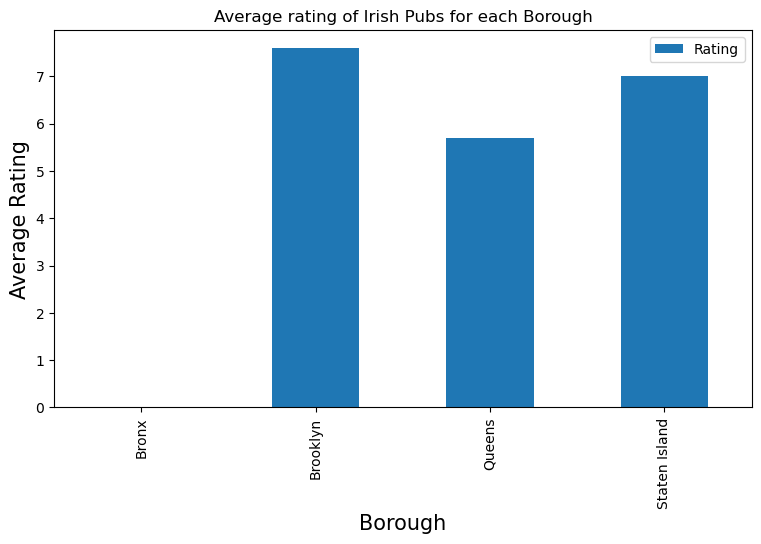

In [58]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Irish Pubs for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
IrishPub_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 7 to visualize on map

In [59]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Astoria,8.1
1,Bay Ridge,7.6
2,Elm Park,7.0
3,Fort Hamilton,7.6
6,Steinway,9.0
7,Westerleigh,7.0


Let's join this dataset to the original new york data to get longitude and latitude.

In [60]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,8.1
1,Brooklyn,Bay Ridge,40.625801,-74.030621,7.6
2,Staten Island,Elm Park,40.630147,-74.141817,7.0
3,Brooklyn,Fort Hamilton,40.614768,-74.031979,7.6
4,Queens,Steinway,40.775923,-73.902290,9.0
5,Staten Island,Westerleigh,40.621090,-74.133041,7.0


Now we will show this data on a map

In [61]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# looping through and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [62]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [63]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
#ny_geo = r'Borough_Boundaries.geojson'
ny_geo = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON'

#ny_map.choropleth(
folium.Choropleth(
    geo_data=ny_geo,
    name='choropleth',
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

ny_map
# display map
# as this is huge map data , we will save it to a file
#ny_map.save('borough_rating.html')

#### Results Discussion and Limitations
From the analysis, out of the 306 neighbourhoods in New York City, only 7 Irish Bars were recorded across the city. This is surprising considering the large number of Irish Bars in New York City. Queens had the highest number of Irish Bars. A key limitation of this is that I am relying on the FourSquare API and there are likely to be many Irish Bars that are not recorded. 

#### Observations
For the Boroughs, Queens has the highest number of Irish Bars. It is observed that the best Irish Bars are also in Queens. 

#### Conclusion
If you are visiting New York and wish to go to an Irish Bar you should make your way out to Queens.